In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import os

# Solved with index_col='client_id' 

In [2]:
PATH_DATA = './data'

# Читаем данные транзакций
transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), header=0, index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), header=0, index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), header=0, index_col='client_id')

# Парсинг времени
transactions['trans_time'] = (
    datetime.datetime(2020, 3, 8, 0, 0, 0)
    - datetime.timedelta(219)
    + pd.to_timedelta(transactions['trans_time'].str.replace(' ', ' days ', n=1))
)

# Разбивка на train test
transactions_train = transactions.join(gender_train, how='inner').drop('Unnamed: 0', axis=1)
transactions_test = transactions.join(gender_test, how='inner').drop('Unnamed: 0', axis=1)

In [3]:
def preprocessing_data(data: pd.DataFrame) -> pd.DataFrame:

    # Выделяем дни недели
    data['weekday'] = data['trans_time'].dt.weekday

    # Делем amount на + и -
    data['amount_up'] = data['amount'].where(data['amount'] >= 0)
    data['amount_down'] = data['amount'].where(data['amount'] <= 0).abs()
    
    # Характеристика по кол-во трат клиентами в дни недели заработок и траты
    aaa = data[['weekday', 'amount_up', 'amount_down']].groupby(['client_id', 'weekday']).count()
    aaa = aaa.unstack(-1)
    aaa.columns = ['_weekday_'.join(map(str, col)).strip() for col in aaa.columns.values]
    data = data.join(aaa, how='inner')

    # Группируем MCC-коды
    # Это точно нужно заменить
    cat_mcc = data["mcc_code"]
    cat_mcc.name = 'mcc_describe'
    
    a = cat_mcc.mask((724 <= cat_mcc) & (cat_mcc < 1799), 1) \
                .mask((1799 <= cat_mcc) & (cat_mcc < 2842) | (4900 <= cat_mcc) & (cat_mcc < 5200) | (5714 <= cat_mcc) & (cat_mcc < 5715) | (9702 <= cat_mcc) & (cat_mcc < 9752), 2) \
                .mask((2842 <= cat_mcc) & (cat_mcc < 3299), 3) \
                .mask((3299 <= cat_mcc) & (cat_mcc < 3441) | (7511 <= cat_mcc) & (cat_mcc < 7519), 4) \
                .mask((3441 <= cat_mcc) & (cat_mcc < 3882) | (6760 <= cat_mcc) & (cat_mcc < 7011), 5) \
                .mask((3882 <= cat_mcc) & (cat_mcc < 4789), 6) \
                .mask((4789 <= cat_mcc) & (cat_mcc < 4900), 7) \
                .mask((5200 <= cat_mcc) & (cat_mcc < 5499), 8) \
                .mask((5499 <= cat_mcc) & (cat_mcc < 5599) | (5699 <= cat_mcc) & (cat_mcc < 5714) | (5969 <= cat_mcc) & (cat_mcc < 5999), 9) \
                .mask((5599 <= cat_mcc) & (cat_mcc < 5699), 10) \
                .mask((5715 <= cat_mcc) & (cat_mcc < 5735) | (5811 <= cat_mcc) & (cat_mcc < 5950), 11) \
                .mask((5735 <= cat_mcc) & (cat_mcc < 5811) | (5999 <= cat_mcc) & (cat_mcc < 6760) | (5962 <= cat_mcc) & (cat_mcc < 5963) | (7011 <= cat_mcc) & (cat_mcc < 7033), 12) \
                .mask((5950 <= cat_mcc) & (cat_mcc < 5962) | (5963 <= cat_mcc) & (cat_mcc < 5969), 13) \
                .mask((7033 <= cat_mcc) & (cat_mcc < 7299), 14) \
                .mask((7299 <= cat_mcc) & (cat_mcc < 7511) | (7519 <= cat_mcc) & (cat_mcc < 7523), 15) \
                .mask((7523 <= cat_mcc) & (cat_mcc < 7699), 16) \
                .mask((7699 <= cat_mcc) & (cat_mcc < 7999), 17) \
                .mask((7999 <= cat_mcc) & (cat_mcc < 8351), 18) \
                .mask((8351 <= cat_mcc) & (cat_mcc < 8699), 19) \
                .mask((8699 <= cat_mcc) & (cat_mcc < 8999), 20) \
                .mask((8999 <= cat_mcc) & (cat_mcc < 9702) | (9752 <= cat_mcc) & (cat_mcc < 9754), 21) \
                .astype('category')
    
    data['mcc_describe'] = a

    # Другая характеристика по клиенту
    tmp = (
        data[['amount_up', 'amount_down', 'term_id', 'trans_type', 'mcc_code']]
        .groupby('client_id')
        .agg({
             'amount_up': ['mean', 'median', 'std', 'count', 'sum'],
             'amount_down': ['mean', 'median', 'std', 'count', 'sum'],
             'term_id': 'nunique',
             'trans_type': 'nunique',
             'mcc_code': 'nunique'
        })
    )
    tmp.columns = ['_client_'.join(col).strip() for col in tmp.columns.values]
    data = data.join(tmp, how='inner')

    # Заработок - траты
    data['delta+-'] = data['amount_up_client_sum'] - data['amount_down_client_sum']

    # Частота покупок за время существования
    days_df = data.groupby('client_id').agg({'trans_time': ['min', 'max']}).diff(axis=1).dropna(axis=1)
    days_df.columns = ['days']
    all_time_freq = (data.index.value_counts() / days_df['days'].dt.days).rename('all_time_freq')
    data = data.join(all_time_freq, how='inner')

    # Убираем лишние столбцы
    data.drop(['amount', 'amount_up', 'amount_down', 'weekday', 'trans_time', 'term_id'], axis=1, inplace=True)
    
    # Приведение типов
    data = data.astype({'mcc_code': 'category', 'trans_type': 'category'})

    return data

# Так выглядел раньше
не нужно её запускать

In [4]:
train = preprocessing_data(transactions_train, transactions)
test = preprocessing_data(transactions_test, transactions)

print(f'{train.shape = }')
print(f'{test.shape = }')

train.shape = (3238732, 35)
test.shape = (324797, 35)


# Так выглядит сейчас

In [4]:
train = preprocessing_data(transactions_train)
test = preprocessing_data(transactions_test)

print(f'{train.shape = }')
print(f'{test.shape = }')

train.shape = (3238732, 34)
test.shape = (324797, 33)


# Catboost

In [6]:
X_train, X_v, y_train, y_v = train_test_split(train.drop('gender', axis=1),
                                              train.gender,
                                              train_size=0.7, 
                                              random_state=234)
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.1,
    custom_loss='AUC',
    verbose=100
)
model.fit(
    X_train, y_train,
    cat_features=['mcc_code', 'trans_type', 'trans_city', 'mcc_describe'],
    eval_set=(X_v, y_v),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6608288	test: 0.6608924	best: 0.6608924 (0)	total: 910ms	remaining: 1m 30s
99:	learn: 0.3892154	test: 0.3898158	best: 0.3898158 (99)	total: 1m 19s	remaining: 0us

bestTest = 0.3898157657
bestIteration = 99



# Эти функции парсят время

In [86]:
%%timeit -r 10
(
    datetime.datetime(2020, 3, 8, 0, 0, 0)
    - datetime.timedelta(219)
    + pd.to_timedelta(transactions['trans_time'].str.replace(' ', ' days ', n=1))
)

7.73 s ± 32.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [74]:
%%timeit -r 10
day_time = transactions['trans_time'].str.split(' ', n=1, expand=True)
start_date = datetime.datetime(2020, 3, 8, 0, 0, 0) - datetime.timedelta(219)
start_date + pd.to_timedelta(day_time[0].astype(int), unit="D") + pd.to_timedelta(day_time[1])

6.41 s ± 94 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [76]:
%%timeit -r 10
day_time = (
    transactions['trans_time'].str.split(' ', n=1, expand=True)
    .rename(columns={0: 'day', 1: 'clock'})
    .astype({'day': int})
)
start_date = datetime.datetime(2020, 3, 8, 0, 0, 0) - datetime.timedelta(219)
start_date + pd.to_timedelta(day_time['day'], unit="D") + pd.to_timedelta(day_time['clock'])

6.75 s ± 136 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [47]:
transactions.astype({'mcc_code': 'category', 'trans_type': 'category'})

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,weekday,amount_up,amount_down
client_id,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,2019-09-06 08:24:41,4829,2370,-1808.56,NaN,Tver,4,NaN,1808.56
81c7349f7bdcb661bc7d5f5f0fdac6aa,2020-07-18 13:27:15,6011,7010,7954.51,442207,Kazan,5,7954.51,NaN
fc0c7c937f139bd6d1c5b5d0a0023dd3,2019-12-30 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,0,NaN,12293.56
3495487d5beaa5caaa0682fddc38379a,2020-08-09 11:54:12,6010,7070,49.52,888987,Kaliningrad,6,49.52,NaN
07e279042b1da23710fa2f65034d30b9,2020-07-07 13:11:45,6010,7070,45.29,888918,Saint Petersburg,1,45.29,NaN
...,...,...,...,...,...,...,...,...,...
e91858185ae43cf3970220748893a01b,2020-06-25 13:45:38,6010,7070,227.40,888907,Penza,3,227.40,NaN
429b6c8255f13bdb506fdbd6e342ccb1,2019-08-12 19:22:35,4814,1030,-1084.44,NaN,Khabarovsk,0,NaN,1084.44
9443b6a0d948cf368d8d72eb295bdfdf,2020-01-16 23:59:15,5411,1110,-569.20,NaN,Tver,3,NaN,569.20


In [234]:
tmp = day_time.groupby('gender').sample(n=1677628)

In [235]:
tmp2 = tmp.groupby(['gender', 'day']).count()

In [236]:
tmp2

time   MCC  hour
gender day                  
False  0    3096  3096  3096
       1    2581  2581  2581
       2    2182  2182  2182
       3    2850  2850  2850
       4    3025  3025  3025
...          ...   ...   ...
True   452  4230  4230  4230
       453  4478  4478  4478
       454  4335  4335  4335
       455  4720  4720  4720
       456  3959  3959  3959

[914 rows x 3 columns]

In [ ]:
tmp3 = tmp.groupby(['day', 'gender']).count()

Text(0, 0.5, 'Колличество покупок')

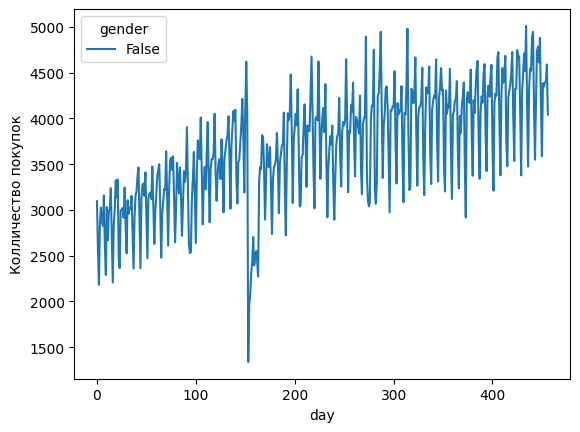

In [237]:
sns.lineplot(data=tmp2.iloc[:lsp, :], x='day', y='MCC', hue='gender')
plt.ylabel('Колличество покупок')

Text(0, 0.5, 'Колличество покупок')

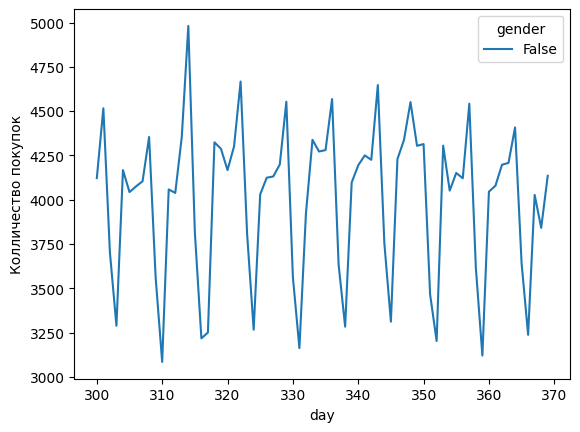

In [238]:
sns.lineplot(data=tmp2.iloc[300:370, :], x='day', y='MCC', hue='gender')
plt.ylabel('Колличество покупок')

Text(0, 0.5, 'Колличество покупок')

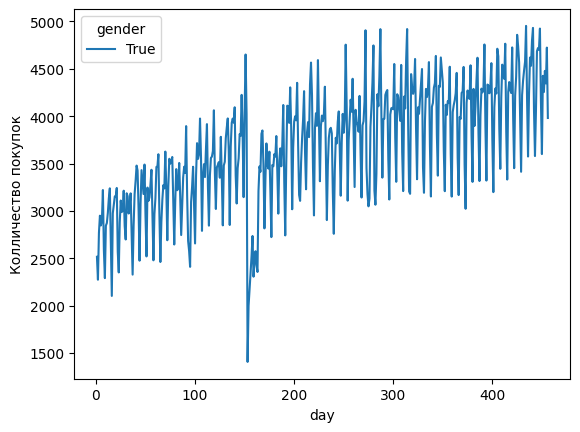

In [58]:
sns.lineplot(data=tmp2.iloc[lsp+1:, :], x='day', y='MCC', hue='gender')
plt.ylabel('Колличество покупок')

Text(0, 0.5, 'Колличество покупок')

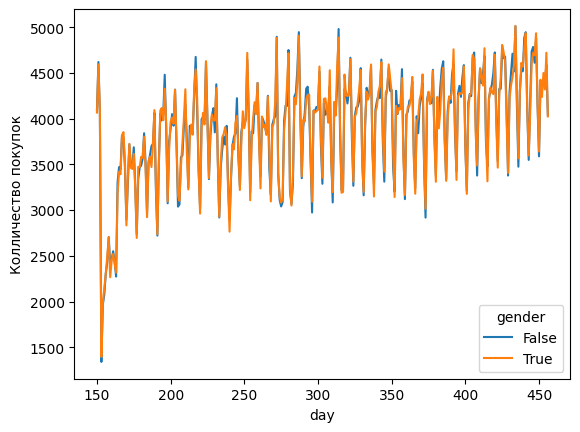

In [60]:
sns.lineplot(data=tmp3.iloc[300:, :], x='day', y='MCC', hue='gender')
plt.ylabel('Колличество покупок')

In [50]:
(lsp := int(len(tmp)/2))

457

In [31]:
1885901 - 1677628

208273

In [25]:
def nuniques_df(dataframe: pd.DataFrame, grouper: str, name: str) -> None:
    group_keys_ = dataframe.groupby(grouper).groups.keys()
    tmp = [dataframe[dataframe[grouper] == i].nunique() for i in group_keys_]
    res = pd.concat([dataframe.nunique(), *tmp], axis=1)
    res.columns = ['All', *group_keys_]
    print(f'Группируем {name} по {grouper}: \n{res}')

In [62]:
nuniques_df(day_time, 'gender', 'day_time')

Группируем day_time по gender: 
          All  False   True
day       457    457    457
time    86383  85699  85950
MCC       184    184    184
gender      2      1      1


In [61]:
group = day_time.groupby("gender", as_index=False).agg({"MCC": "unique"}).reset_index(drop=True)

all_uniq = set(day_time["MCC"])

x = group[group['gender'] == 0]["MCC"]
a0 = set(x.to_numpy()[0])
x1 = group[group['gender'] == 1]["MCC"]
a1 = set(x1.to_numpy()[0])

tiff0 = all_uniq - a1
tiff1 = all_uniq - a0
print(all_uniq - a0)


dic = {"gender=1" : tiff1, "gender=0" : tiff0}
pprint(dic)

set()
{'gender=0': set(), 'gender=1': set()}


<Axes: xlabel='MCC', ylabel='Count'>

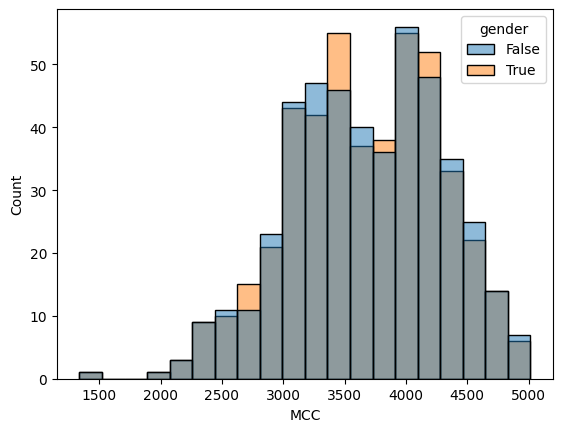

In [66]:
sns.histplot(tmp, hue='gender', x='MCC')

In [132]:
(df_tmp := day_time[['gender', 'MCC']].groupby('gender').sample(n=1677628).groupby('gender', as_index=False).value_counts())

,gender,MCC,count
0,False,6011,364509
1,False,4814,245556
2,False,5411,240616
3,False,6010,225939
4,False,4829,147982
...,...,...,...
363,True,5971,14
364,True,2741,12
365,True,7829,11
366,True,5697,8


In [130]:
df_tmp['count'].sum() == 1677628 * 2

True

In [126]:
b = df_tmp.query('gender == False')[['MCC', 'count']].set_index('MCC', drop=True)
b.columns = ['count_False']

a = df_tmp.query('gender == True')[['MCC', 'count']].set_index('MCC', drop=True)
a.columns = ['count_True']

c = pd.concat([a, b], axis=1)
c['diff_T-F'] = c['count_True'] - c['count_False']
c

,count_True,count_False,diff_T-F
MCC,,,
6011,363049,364509,-1460
4814,245077,245556,-479
5411,241638,240616,1022
6010,225447,225939,-492
4829,148403,147982,421
...,...,...,...
5971,14,14,0
2741,11,10,1
7829,11,19,-8


In [127]:
c['diff_T-F'].describe()

count     184.000000
mean        0.000000
std       157.185769
min     -1460.000000
25%       -12.750000
50%        -3.000000
75%        15.250000
max      1022.000000
Name: diff_T-F, dtype: float64

In [157]:
day_time.head(10)

,day,time,MCC,gender,hour
0,35,08:24:41,4829,False,08
1,351,13:27:15,6011,False,13
2,150,16:03:59,6011,False,16
3,373,11:54:12,6010,False,11
4,340,13:11:45,6010,False,13
5,117,11:28:27,6011,False,11
6,104,20:08:34,4814,False,20
7,368,09:33:25,4829,False,09
8,295,00:00:41,5411,False,00
9,27,19:07:08,5411,False,19


In [116]:
df_tmp.query('gender == False')

,gender,MCC,count
0,False,6011,364509
1,False,4814,245556
2,False,5411,240616
3,False,6010,225939
4,False,4829,147982
...,...,...,...
179,False,7629,14
180,False,7531,13
181,False,8244,10
182,False,2741,10


In [89]:
day_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563529 entries, 0 to 3563528
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   day     int64 
 1   time    object
 2   MCC     int64 
 3   gender  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 85.0+ MB


In [136]:
day_time['hour'] = day_time['time'].apply(lambda x: x.split(':')[0])

In [151]:
(df_tmp2 := day_time[['gender', 'hour']].groupby('gender').sample(n=1677628).groupby(['gender', 'hour'], as_index=False)['hour'].count())
df_tmp2['index_hour'] = [*range(24), *range(24)]
df_tmp2

,gender,hour,index_hour
0,False,112305,0
1,False,10525,1
2,False,11479,2
3,False,14225,3
4,False,18490,4
5,False,25743,5
6,False,35676,6
7,False,49604,7
8,False,68895,8
9,False,84351,9


<Axes: xlabel='index_hour', ylabel='hour'>

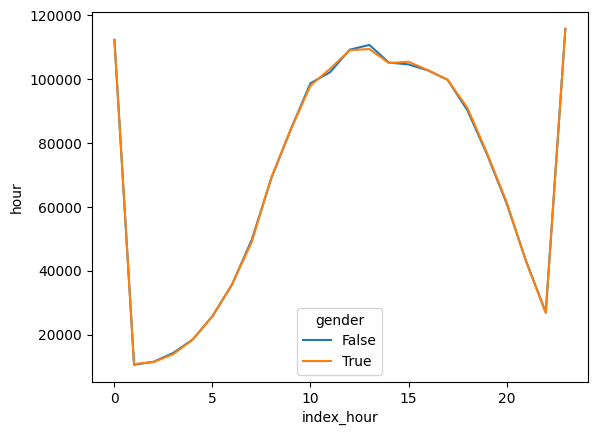

In [154]:
sns.lineplot(data=df_tmp2, y='hour', x='index_hour', hue='gender')

<Axes: xlabel='hour', ylabel='MCC'>

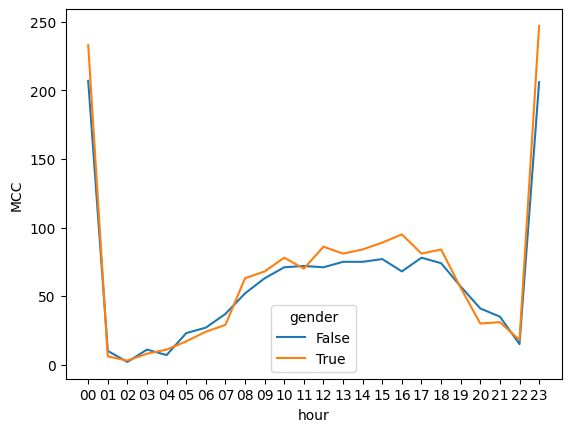

In [177]:
sns.lineplot(data=day_time.drop('time', axis=1).query('MCC == 5992').groupby(['gender', 'hour'], as_index=False)['MCC'].count(), x='hour', y='MCC', hue='gender')

<Axes: xlabel='day', ylabel='MCC'>

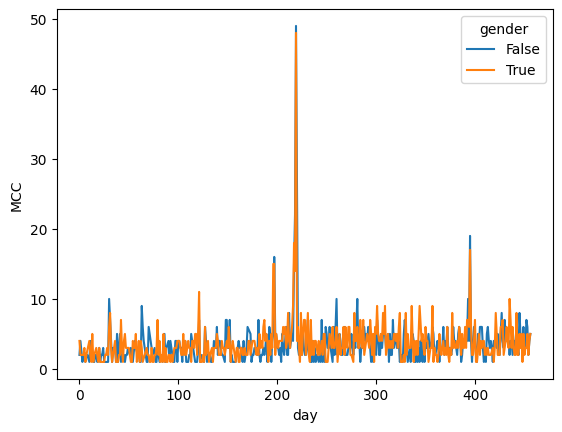

In [193]:
sns.lineplot(data=day_time.drop('time', axis=1).query('MCC == 5992').groupby(['gender', 'day'], as_index=False)['MCC'].count(), x='day', y='MCC', hue='gender')

In [267]:
day_time.drop('time', axis=1).query('MCC == 5992').groupby(['gender', 'day'], as_index=False)['MCC'].count().sort_values('MCC', ascending=False)

,gender,day,MCC
191,False,219,49
624,True,219,48
190,False,218,22
360,False,395,19
622,True,217,18
...,...,...,...
155,False,183,1
311,False,344,1
654,True,251,1
758,True,358,1


<Axes: xlabel='day', ylabel='MCC'>

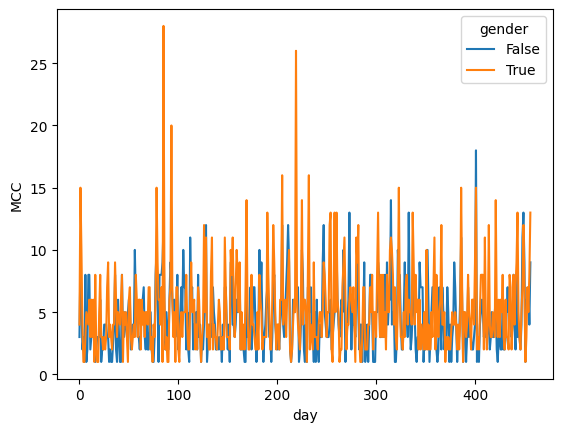

In [245]:
sns.lineplot(data=day_time.drop('time', axis=1).query('MCC == 5813').groupby(['gender', 'day'], as_index=False)['MCC'].count(), x='day', y='MCC', hue='gender')

In [247]:
day_week = day_time.drop('time', axis=1).query('MCC == 5813').groupby(['gender', 'day'], as_index=False)['MCC'].count()
day_week

,gender,day,MCC
0,False,0,3
1,False,1,9
2,False,2,6
3,False,3,2
4,False,4,3
...,...,...,...
891,True,452,3
892,True,453,7
893,True,454,5
894,True,455,8


In [ ]:
day_week['day'] = day_week['day'].apply(lambda x: x % 7)

In [251]:
day_week.drop('gender', axis=1).groupby('day').count()

,MCC
day,
0,2
1,2
2,2
3,2
4,2
...,...
452,2
453,2
454,2


In [252]:
res.isna().sum()

client_id           0
trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
gender         324797
dtype: int64

In [255]:
day_week = day_time.drop(columns=['time', 'hour'])
day_week['day'] = day_week['day'].apply(lambda x: x % 7)
day_week

,day,MCC,gender
0,0,4829,False
1,1,6011,False
2,3,6011,False
3,2,6010,False
4,4,6010,False
...,...,...,...
3563524,6,6010,True
3563525,3,4814,False
3563526,6,5411,False
3563527,3,5814,False


In [261]:
day_week.drop('gender', axis=1).groupby('day').count()

,MCC
day,
0,573489
1,484510
2,412252
3,500893
4,525464
5,531443
6,535478


<Axes: xlabel='day'>

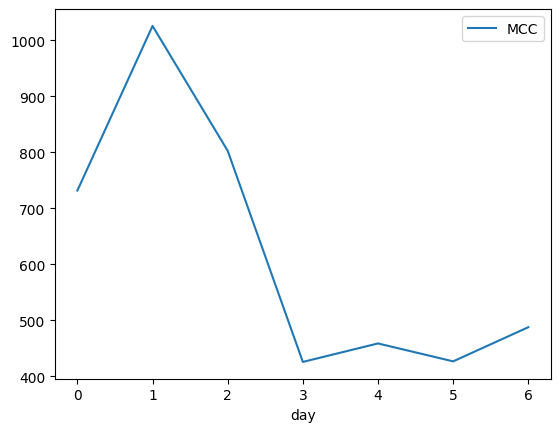

In [265]:
day_week.drop('gender', axis=1).query('MCC == 5813').groupby('day').count().plot.line()

<Axes: xlabel='day'>

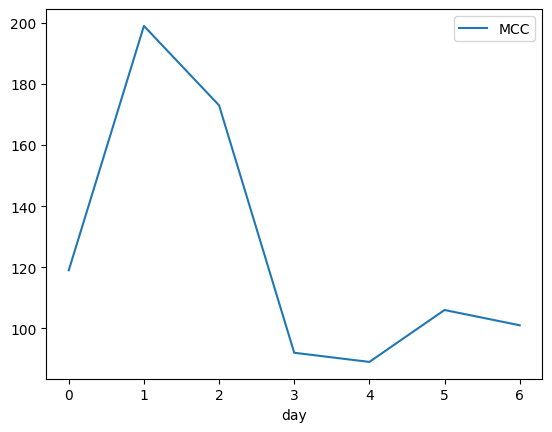

In [266]:
day_week.drop('gender', axis=1).query('MCC == 5611').groupby('day').count().plot.line()

In [268]:
219 % 7

2

In [ ]:
year = 2020

In [239]:
day_time.drop('time', axis=1).query('MCC == 5532').groupby(['gender', 'day'], as_index=False)['MCC'].count()

,gender,day,MCC
0,False,0,9
1,False,1,1
2,False,2,6
3,False,3,3
4,False,4,2
...,...,...,...
886,True,452,2
887,True,453,4
888,True,454,4
889,True,455,8


<Axes: xlabel='day', ylabel='MCC'>

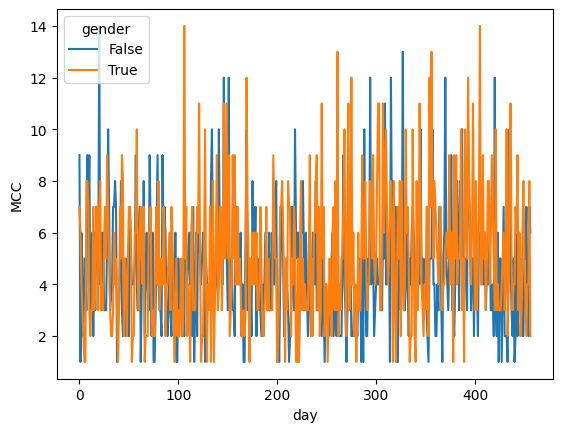

In [241]:

sns.lineplot(data=day_time.drop('time', axis=1).query('MCC == 5621').groupby(['gender', 'day'], as_index=False)['MCC'].count(), x='day', y='MCC', hue='gender')

In [202]:
day_time.drop('time', axis=1).query('MCC == 5532').groupby(['gender', 'day'], as_index=False)['MCC'].count().sort_values('MCC', ascending=False)

,gender,day,MCC
247,True,435,4
122,True,39,3
193,True,271,3
138,True,76,3
137,True,74,3
...,...,...,...
98,False,430,1
99,False,431,1
100,False,432,1
102,False,434,1


In [188]:
abc = day_time.drop('time', axis=1).query('MCC == 5992').groupby(['gender', 'day'], as_index=False)['MCC'].count()

In [191]:
abc.sort_values('MCC', ascending=False)

,gender,day,MCC
191,False,219,49
624,True,219,48
190,False,218,22
360,False,395,19
622,True,217,18
...,...,...,...
155,False,183,1
311,False,344,1
654,True,251,1
758,True,358,1


In [ ]:
219 - 8 марта

In [180]:
res.query('amount < 0').groupby('gender')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
False,1373732.0,-1710.605565,14132.619093,-3543296.91,-733.57,-261.33,-83.21,-0.01
True,1553959.0,-2352.059725,12590.317504,-4338731.90,-1084.02,-315.96,-107.50,-0.01


In [ ]:
True = Мужчины

In [181]:
res.query('amount >= 0').groupby('gender')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
False,303896.0,4712.743241,30930.867229,0.0,252.4200,723.40,2891.5100,3543297.64
True,331942.0,6368.056524,26496.526977,0.0,306.3925,1019.78,3732.7625,4700292.89


In [219]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563529 entries, 0 to 3563528
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   client_id   object 
 1   trans_time  object 
 2   mcc_code    int64  
 3   trans_type  int64  
 4   amount      float64
 5   term_id     object 
 6   trans_city  object 
 7   gender      float64
dtypes: float64(2), int64(2), object(4)
memory usage: 217.5+ MB


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563529 entries, 0 to 3563528
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   client_id   object 
 1   trans_time  object 
 2   mcc_code    int64  
 3   trans_type  int64  
 4   amount      float64
 5   term_id     object 
 6   trans_city  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 190.3+ MB


In [223]:
data.isna().sum()

client_id           0
trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
dtype: int64

In [225]:
genders.isna().sum()

client_id    0
gender       0
dtype: int64

In [40]:
res.shape


(3563529, 35)

In [39]:
data.shape

(3563529, 7)

In [218]:
res.groupby('gender').count()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
gender,,,,,,,
0.0,1677628,1677628,1677628,1677628,1677628,997086,1677628
1.0,1561104,1561104,1561104,1561104,1561104,930598,1561104
